In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold

## 1 Load the data set

In [74]:
df = pd.read_csv("~/downloads/corona_tested_individuals_ver_00166.csv", header=0, parse_dates = ['test_date']) ## load the date in local
# df_np = np.loadtxt('corona_tested_individuals_ver_00166.csv', delimiter=',', skiprows=1,
#                           usecols= (1,7), unpack=True)
# df = pd.DataFrame(df)
df.columns = ['date','cough','fever','sore_throat','shortness_of_breath','head_ache','corona_result','age','gender','test_indication']
df = df[df["date"] > "2021-03-30"]

## 2 Data Exploration¶

Explanation of the data:
https://data.gov.il/dataset/covid-19/resource/0ac4cffc-3746-473a-8d4a-ab874b8d8d62

Gender: appears from March 22nd 2020

Corona_result: Results of first Covid-19 test, by category:
    a.Positive – carrying Covid-19
    b.Negative – not carrying Covid-19
    c.Other – Not tested, in testing, inconclusive

Age_60_and_above: Indicator of the test taker's age - 60 or over (1) or below 60 (0). Appears from March 17th 2020.

Test_indication: What is the indication for testing? Abroad – arrived from abroad, contact_with_confirmed – contact with a confirmed case, other – other indication or not specified

Symptoms (whether developed before testing):
cough, fever, sore_throat, shortness of breath, headache: 1 – Yes, 0 – No, NULL – Unknown

Obviously, the corona_result is the label class.

Here we have questions on 1) how to handle missing age values before March 22 and age before March 17. 2)null values (drop or replace) 3) the meaningful use of test date data

In [75]:
df.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
1,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
2,2021-07-25,1,1,1,0,1,אחר,No,נקבה,Abroad
3,2021-07-25,0,0,0,0,0,שלילי,No,זכר,Other
4,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other


In [76]:
df.shape

(852374, 10)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852374 entries, 0 to 852373
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 852374 non-null  datetime64[ns]
 1   cough                852374 non-null  int64         
 2   fever                852374 non-null  int64         
 3   sore_throat          852374 non-null  int64         
 4   shortness_of_breath  852374 non-null  int64         
 5   head_ache            852374 non-null  int64         
 6   corona_result        852374 non-null  object        
 7   age                  217614 non-null  object        
 8   gender               380625 non-null  object        
 9   test_indication      852374 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 71.5+ MB


In [78]:
df.isnull().sum()

date                        0
cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age                    634760
gender                 471749
test_indication             0
dtype: int64

According to the offical documents, testing for the virus started in February. However,due to privacy concerns:
1. The information is available from 11 March 2020.
2. Ages have been divided to under 60 and 60 and over, and are published from 17 March until 14 April (before 17 March until 14 April age equals NULL)
3. Sex is published from 22 March (before the date, sex was represented as NULL)

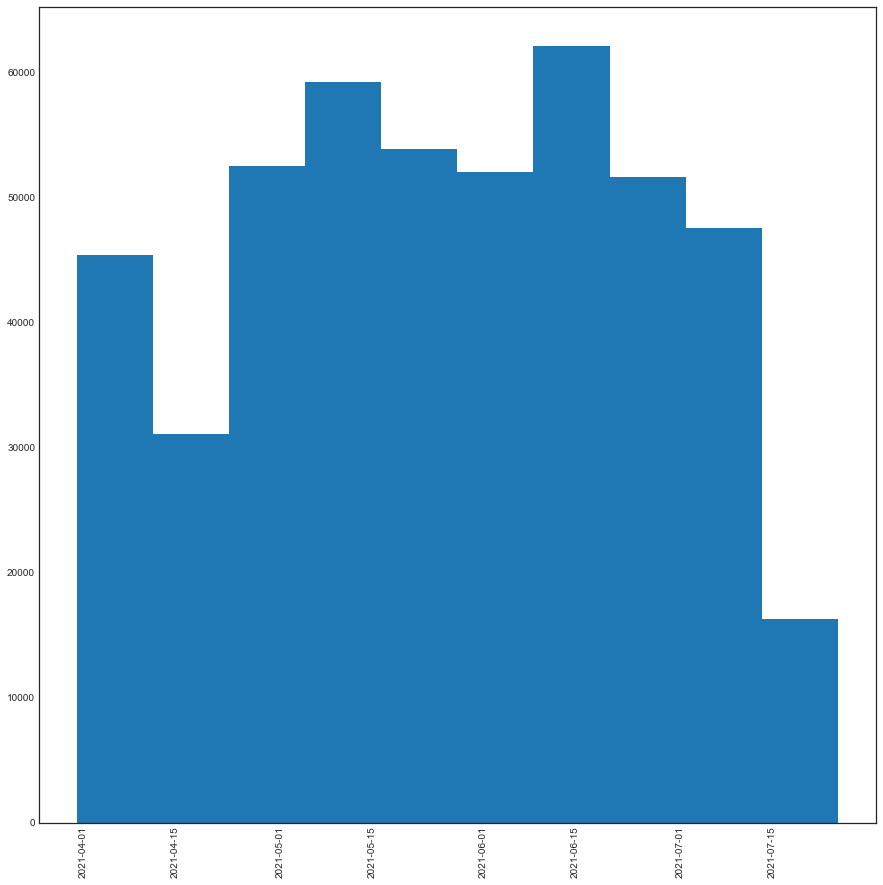

In [79]:
plt.hist(df[df["gender"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

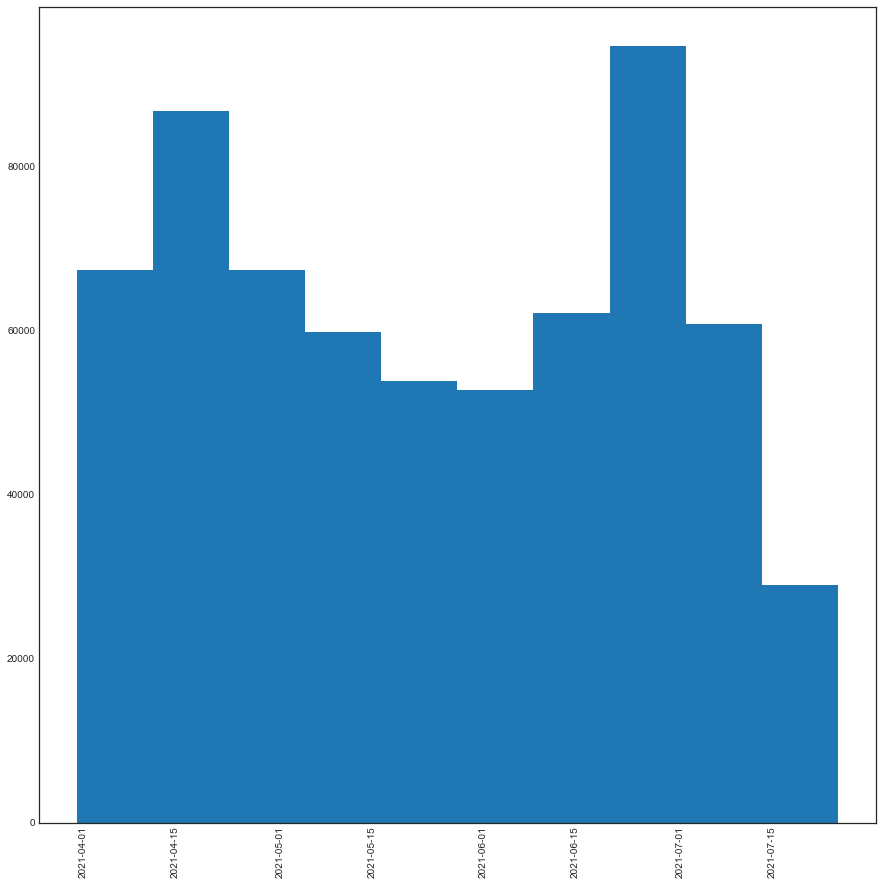

In [80]:
plt.hist(df[df["age"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

In [81]:
pd.concat([
    df.describe().T,
    df.mad().rename('mad'),
    df.skew().rename('skew'),
    df.kurt().rename('kurt'),
    df.nunique().rename('nunique')
], axis=1).T

,cough,fever,sore_throat,shortness_of_breath,head_ache,date,corona_result,age,gender,test_indication
count,852374.000000,852374.000000,852374.000000,852374.000000,852374.000000,NaN,NaN,NaN,NaN,NaN
mean,0.004448,0.003899,0.001553,0.000318,0.002796,NaN,NaN,NaN,NaN,NaN
std,0.066542,0.062316,0.039381,0.017828,0.052801,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
mad,0.008856,0.007767,0.003102,0.000636,0.005576,NaN,NaN,NaN,NaN,NaN
skew,14.894520,15.922066,25.313846,56.056248,18.833309,NaN,NaN,NaN,NaN,NaN


In [82]:
df['corona_result'].unique() 

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

In [83]:
# replacing all the characters in Hebrew by English
df['corona_result'] = df['corona_result'].str.replace('חיובי','Positive')
df['corona_result'] = df['corona_result'].str.replace('אחר','Other')
df['corona_result'] = df['corona_result'].str.replace('שלילי','Negative')

df['gender'] = df['gender'].str.replace('נקבה','Female')
df['gender'] = df['gender'].str.replace('זכר','Male')

## 3 Data Understanding

**BreakDown of Class**

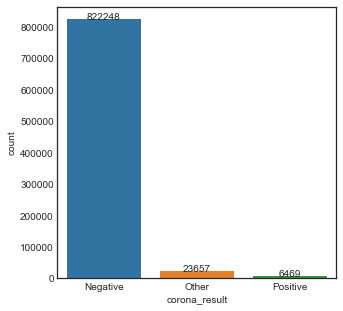

In [84]:
plt.figure(figsize=(5,5))
corona_result = sns.countplot(df['corona_result'],label="Count")

for p in corona_result.patches:
    height = p.get_height()
    corona_result.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

The class lable is highly imbalanced. The proportion of positive instances is less than **5%**. We need to be cautious about this.

**BreakDown of feature distribution**

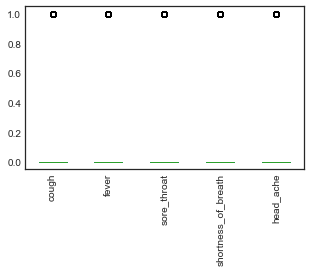

In [85]:
df.plot.box(figsize=(5, 3)) # visualize the feature distribution
plt.xticks(rotation='vertical');
# the value distribution of 5 numeric features are highly skewed with over 75% being 0.

**BreakDown of cough**

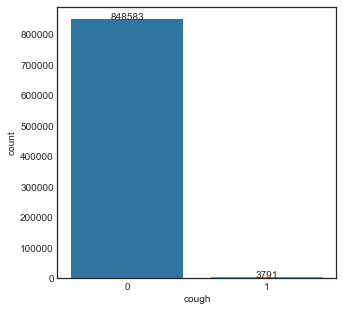

In [86]:
plt.figure(figsize=(5,5))
cough = sns.countplot(data=df, x="cough")

for p in cough.patches:
    height = p.get_height()
    cough.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

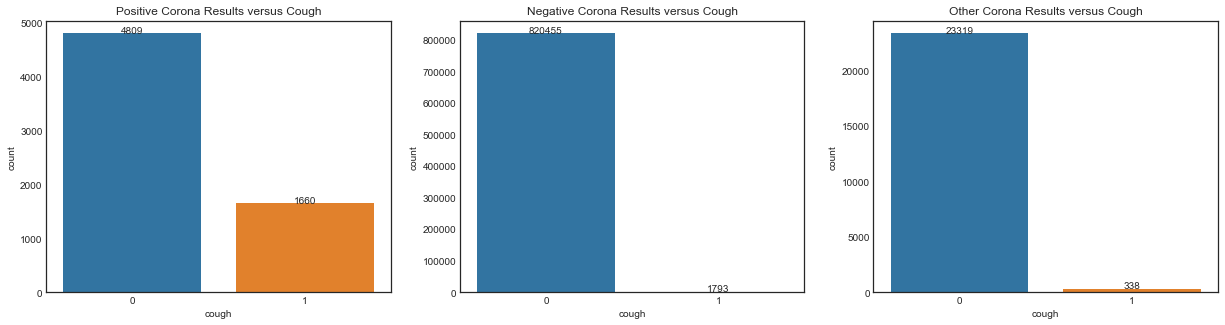

In [87]:
# plt.figure(figsize=(5,5))
#sns.distplot(df[df['corona_result'] == 'Positive']["cough"], color='red', kde=False) 
# we don't need kernel desity estimate because the feature is discrete.
#sns.distplot(df[df['corona_result'] == 'Negative']["cough"], color='green', kde=False)
#plt.title('Corona Results versus Cough')
#plt.show()


f, axes = plt.subplots(1, 3, figsize=(21,5))
positive = sns.countplot(df[df['corona_result'] == 'Positive']["cough"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus Cough")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["cough"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus Cough')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["cough"], ax=axes[2])
axes[2].set_title('Other Corona Results versus Cough')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of fever**

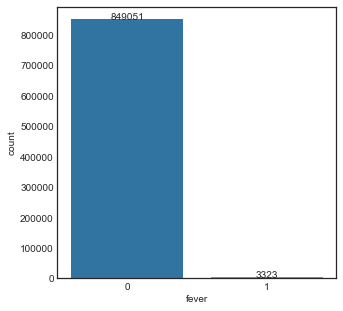

In [88]:
#p = sns.countplot(data=df, x="fever")
#plt.show()

plt.figure(figsize=(5,5))
fever = sns.countplot(data=df, x="fever")

for p in fever.patches:
    height = p.get_height()
    fever.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

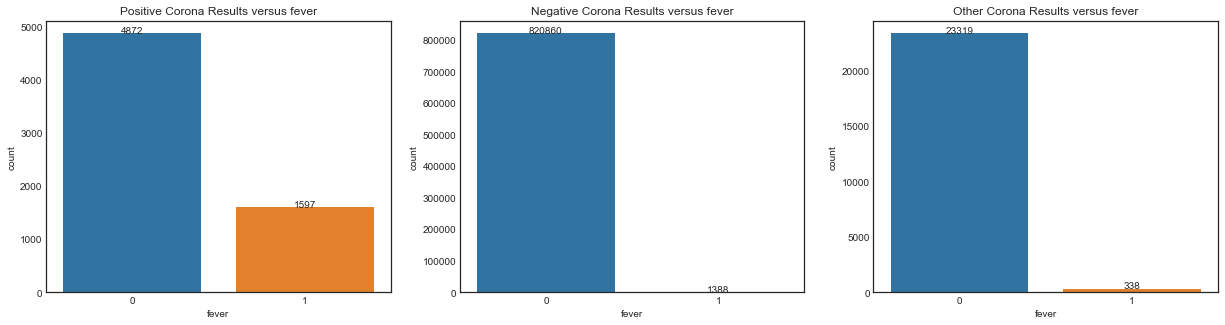

In [89]:
#plt.figure(figsize=(5,5))
#sns.distplot(df[df['corona_result'] == 'Positive']["fever"], color='red',kde=False) 
#sns.distplot(df[df['corona_result'] == 'Negative']["fever"], color='green',kde=False)
#plt.title('Corona Results versus Fever')
#plt.show()


f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["fever"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus fever")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["fever"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus fever')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["fever"], ax=axes[2])
axes[2].set_title('Other Corona Results versus fever')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of sore_throat**

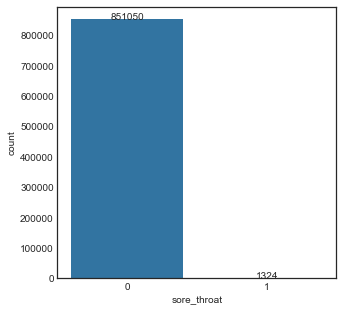

In [90]:
#p = sns.countplot(data=df, x="sore_throat")
#plt.show()

plt.figure(figsize=(5,5))
sore_throat = sns.countplot(data=df, x="sore_throat")

for p in sore_throat.patches:
    height = p.get_height()
    sore_throat.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")



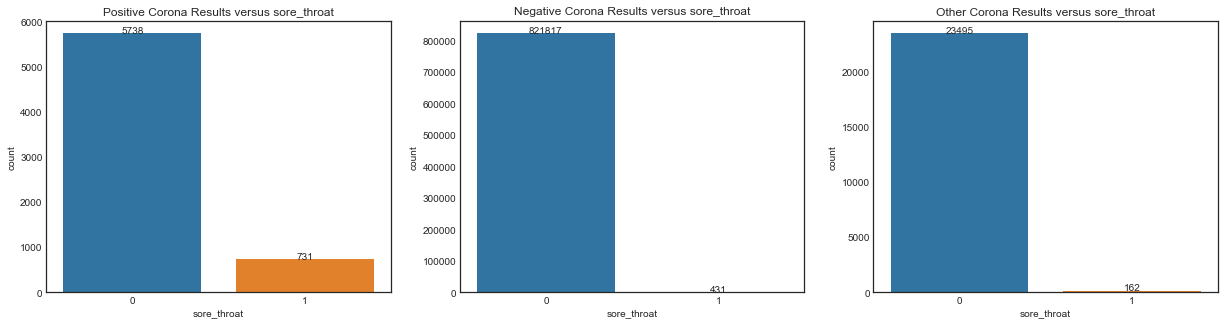

In [91]:
#plt.figure(figsize=(5,5))
#sns.distplot(df[df['corona_result'] == 'Positive']["sore_throat"], color='red',kde=False) 
#sns.distplot(df[df['corona_result'] == 'Negative']["sore_throat"], color='green',kde=False)
#plt.title('Corona Results versus sore_throat')
#plt.show()

f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["sore_throat"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus sore_throat")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["sore_throat"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus sore_throat')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["sore_throat"], ax=axes[2])
axes[2].set_title('Other Corona Results versus sore_throat')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of shortness_of_breath**

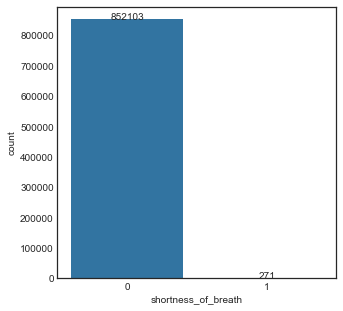

In [92]:
#p = sns.countplot(data=df, x="shortness_of_breath")
#plt.show()

plt.figure(figsize=(5,5))
shortness_of_breath = sns.countplot(data=df, x="shortness_of_breath")

for p in shortness_of_breath.patches:
    height = p.get_height()
    shortness_of_breath.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

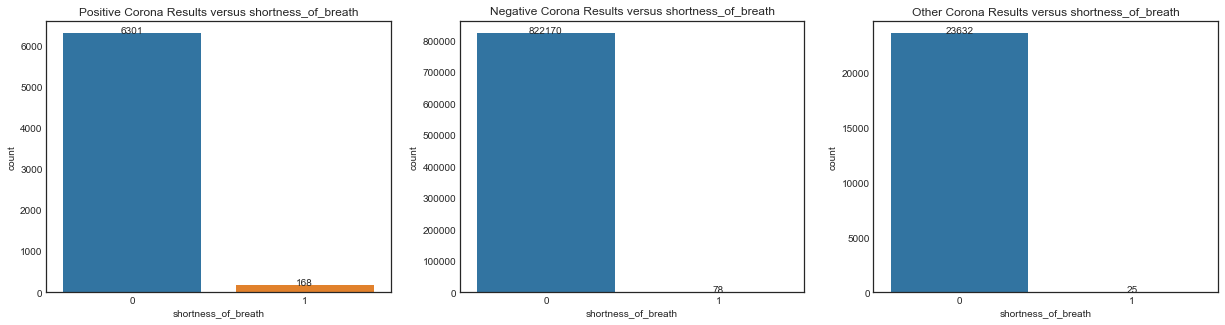

In [93]:
#plt.figure(figsize=(5,5))
#sns.distplot(df[df['corona_result'] == 'Positive']["shortness_of_breath"], color='red',kde=False) 
#sns.distplot(df[df['corona_result'] == 'Negative']["shortness_of_breath"], color='green',kde=False)
#plt.title('Corona Results versus shortness_of_breath')
#plt.show()

f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["shortness_of_breath"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus shortness_of_breath")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["shortness_of_breath"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus shortness_of_breath')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["shortness_of_breath"], ax=axes[2])
axes[2].set_title('Other Corona Results versus shortness_of_breath')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of head_ache**

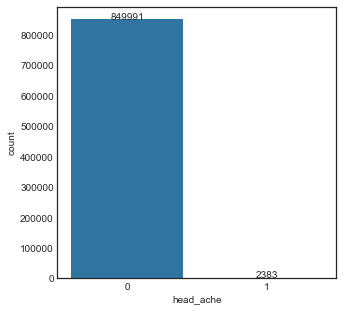

In [94]:
#p = sns.countplot(data=df, x="head_ache")
#plt.show()

plt.figure(figsize=(5,5))
head_ache = sns.countplot(data=df, x="head_ache")

for p in head_ache.patches:
    height = p.get_height()
    head_ache.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

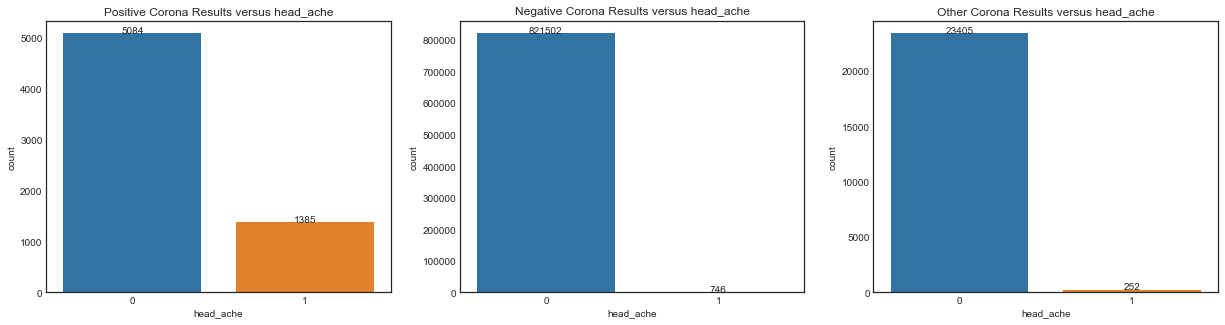

In [95]:
#plt.figure(figsize=(5,5))
#sns.distplot(df[df['corona_result'] == 'Positive']["head_ache"], color='red',kde=False) 
#sns.distplot(df[df['corona_result'] == 'Negative']["head_ache"], color='green',kde=False)
#plt.title('Corona Results versus head_ache')
#plt.show()

f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["head_ache"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus head_ache")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["head_ache"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus head_ache')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["head_ache"], ax=axes[2])
axes[2].set_title('Other Corona Results versus head_ache')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()

**Corona Result along with time**

In [96]:
matplotlib.style.use('seaborn-white')

In [97]:
df

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
1,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
2,2021-07-25,1,1,1,0,1,Other,No,Female,Abroad
3,2021-07-25,0,0,0,0,0,Negative,No,Male,Other
4,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
...,...,...,...,...,...,...,...,...,...,...
852369,2021-03-31,0,0,0,0,0,Negative,No,NaN,Other
852370,2021-03-31,0,0,0,0,0,Negative,No,NaN,Other
852371,2021-03-31,0,0,0,0,0,Negative,No,NaN,Other
852372,2021-03-31,0,0,0,0,0,Negative,No,NaN,Other


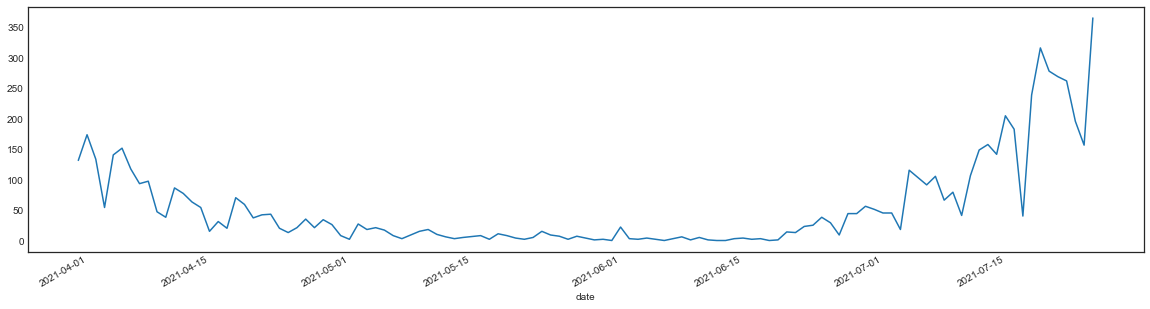

In [98]:
df[df['corona_result'] == "Positive"].groupby('date').size().plot(figsize=(20, 5));

There are two peaks for testing positive results in 2021-07-25 and 2021-07-19

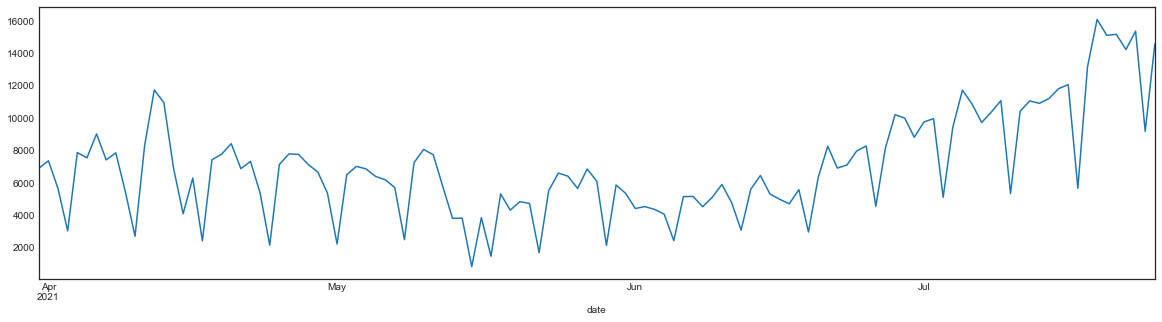

In [99]:
df[df['corona_result'] == "Negative"].groupby('date').size().plot(figsize=(20, 5));

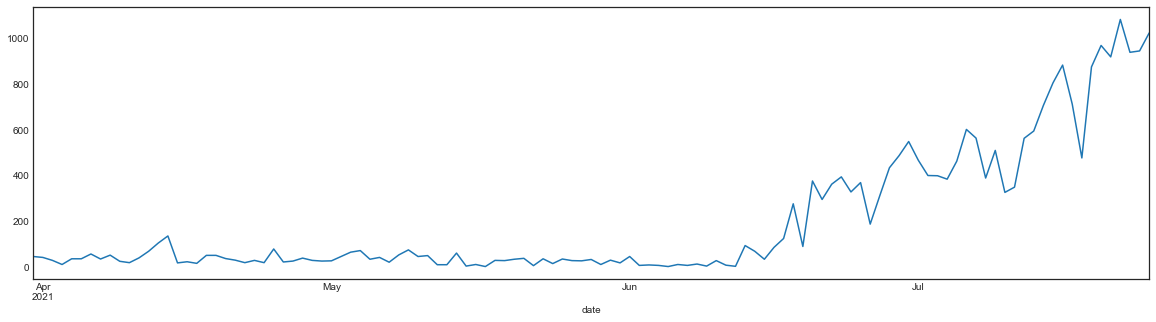

In [100]:
df[df['corona_result'] == "Other"].groupby('date').size().plot(figsize=(20, 5));

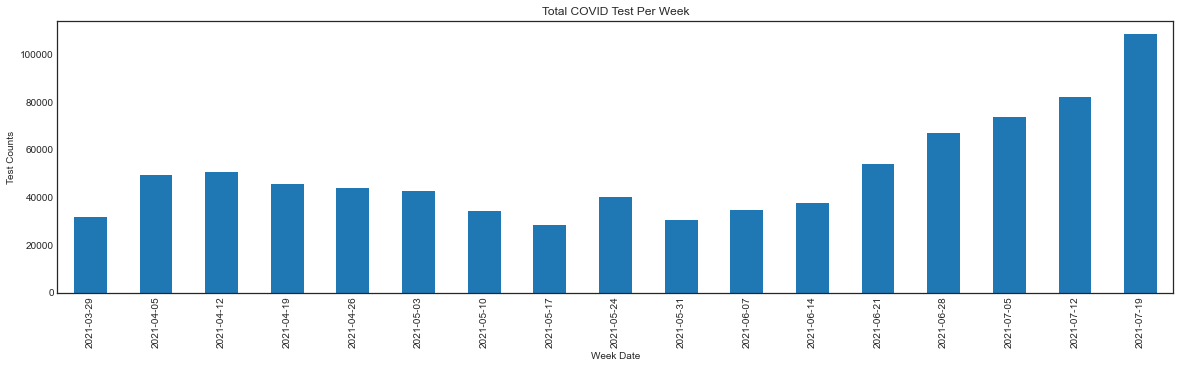

In [101]:
import pandas as pd, datetime as dt

df_weekly = pd.DataFrame(df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1), columns = ['WeekDate'])
df_weekly['WeekDate'] = pd.to_datetime(df_weekly['WeekDate']).dt.date

perweek = df_weekly['WeekDate'].groupby(df_weekly['WeekDate']).count()
perweek.plot(kind="bar", figsize=(20, 5));
plt.title("Total COVID Test Per Week")
plt.xlabel("Week Date")
plt.ylabel("Test Counts")
plt.show()

Combining what we have analyzed above, the volume of test cases varies week by week but is generally trending upwards.

## 4 Data Preprocessing

**Remove the instances with results of *Others* (not tested, testing)**

In [29]:
df = df[df['corona_result'] != 'Other']
df = df.drop("date", axis = 1)

### Imputation

In [30]:
# How many features have missing values?
n_missing = len(df.columns[df.isnull().any()])
"{} features have missing values.".format(n_missing)

'2 features have missing values.'

In [31]:
keys = ['Total', 'Percent']

null_total = df.isnull().sum().sort_values(ascending=False)
null_percent = (df.isnull().sum() /df.isnull().count())

df_missing = pd.concat([null_total, null_percent], axis=1, keys=keys, sort=False)
df_missing = df_missing.sort_values(by='Percent', ascending=False)
df_missing.head(n_missing)

,Total,Percent
age,622948,0.751702
gender,463000,0.558695


The percentage of the missing values is large. We will test on filled and dropped datasets and see if one improves the accuracy

In [32]:
# replace the missing value
X_filled = df.copy().drop("corona_result", axis = 1)
y_filled = df.copy()["corona_result"]
X_filled_nom = X_filled.select_dtypes(include=[object])
X_filled_num = X_filled.select_dtypes(include=[np.number])

X_filled[X_filled_nom.columns] = X_filled_nom.fillna('Missing')
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,test_indication
0,0,0,0,0,0,No,Female,Other
1,0,0,0,0,0,No,Female,Other
3,0,0,0,0,0,No,Male,Other
4,0,0,0,0,0,No,Female,Other
5,0,0,0,0,0,No,Missing,Other


In [33]:
# drop the rows with missing value
df_dropped = df.dropna(how = 'any', axis=0)
X_dropped = df_dropped.drop("corona_result", axis = 1)
y_dropped = df_dropped["corona_result"]

In [34]:
n_missing = len(X_dropped.columns[X_dropped.isnull().any()])
"{} features have missing values.".format(n_missing)

'0 features have missing values.'

### Encoding

In [35]:
X_filled_nom_trans = pd.get_dummies(X_filled[X_filled_nom.columns])

In [36]:
X_filled = pd.concat([X_filled_num, X_filled_nom_trans], axis = 1)

In [37]:
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_Missing,age_No,age_Yes,gender_Female,gender_Male,gender_Missing,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,1,0,1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,1,0,0,1


**When dropping the missing value, the two nominal features (gender and age) are all binary feature. Thus we can encode these features as 0 and 1**

In [38]:
# gender and age features are binary so use labelEncoder to be consistent with the syndrome features (binary)
le = LabelEncoder()
le.fit(X_dropped["gender"])
X_dropped["gender"] = le.transform(X_dropped["gender"])
le.fit(X_dropped["age"])
X_dropped["age"] = le.transform(X_dropped["age"])
# X_indication have multi variable so use get dummies instead. OneHotEncoder can't convert df with some string
X_indication = pd.get_dummies(X_dropped["test_indication"])
X_dropped = pd.concat([X_dropped.drop("test_indication", axis=1), X_indication], axis=1)

In [39]:
X_dropped.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,Abroad,Contact with confirmed,Other
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,1,0,0,1


**Encoding the class label value**

In [40]:
le.fit(y_dropped)
y_dropped = le.transform(y_dropped)
le.fit(y_filled)
y_filled = le.transform(y_filled)

NOTE: moved feature selection to after modeling as we want to see the baseline performance scores and some features selections are based on models

<!-- **Correlation between features in X_dropped (missing values dropped)** -->

In [41]:
# plt.rc("figure", figsize=(15, 15))
# grid=sns.heatmap(corr2,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
# grid.set_xticklabels(corr2.columns,rotation=90)
# plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
# plt.show()

## Modeling

In [47]:
models = {
    "Perceptron": Perceptron(),
    "KNN (n_neighbors=10)": KNeighborsClassifier(n_neighbors=10),
    "KNN (n_neighbors=50)": KNeighborsClassifier(n_neighbors=50),
    "Decision Tree (max_depth=None)": DecisionTreeClassifier(max_depth=None, random_state=0),
    "Decision Tree (max_depth=25)": DecisionTreeClassifier(max_depth=25, random_state=0),
    "GNB": GaussianNB(),
    "MNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(random_state=0),
    "XGBoost": XGBClassifier(n_estimators=1000, tree_method='hist', random_state=0)
}

In [42]:
def evaluate(y_test, y_pred):
    output = dict()
    output["Accuracy"] = accuracy_score(y_test, y_pred)
    output["AUROC"] = roc_auc_score(y_test, y_pred)
    output["f1"] = f1_score(y_test, y_pred)
    return output

In [49]:
predictions = dict()

In [107]:
# train test random split using data filled
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)

In [48]:
# for key in models.keys():
#     clf = models[key]
#     clf.fit(x_train, y_train)
#     predictions[key] = clf.predict(x_test)

In [52]:
# comment out for now as it keep erroring out

#results = pd.DataFrame([evaluate(y_test, predictions[key]) for key in models.keys()], index=models.keys())
#results.sort_values('AUROC', ascending=False)

**Performance metrics tailored for imbalanced data**

https://imbalanced-learn.org/stable/references/metrics.html#module-imblearn.metrics

In [43]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import sensitivity_specificity_support
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import macro_averaged_mean_absolute_error

In [44]:
def evaluate_imbalanced(y_test, y_pred):
    output = dict()
    output["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)
    output["Sensitivity"] = sensitivity_score(y_test, y_pred, average='weighted') ## high indicates low false negative
    output["Specificity"] = specificity_score(y_test, y_pred, average='weighted') ## high indicates low false positive
    output["AUROC"] = roc_auc_score(y_test, y_pred) ##TPR
    output["F1"] = f1_score(y_test, y_pred) ##weighted precision and recall (both positive dominated)
    output["Geometric Mean"] = geometric_mean_score(y_test, y_pred, average='weighted') ## class-wise sensitivity
    output["Macro Average MAE"] = macro_averaged_mean_absolute_error(y_test, y_pred)
    return output

The sensitivity is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
The sensitivity quantifies the ability to avoid false negatives.
The best value is 1 and the worst value is 0.

'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

The specificity is the ratio tn / (tn + fp) where tn is the number of true negatives and fp the number of false positives. The specificity quantifies the ability to avoid false positives. The best value is 1 and the worst value is 0.

The geometric mean (G-mean) is the root of the product of class-wise sensitivity. 

This function computes each MAE for each class and average them, giving an equal weight to each class.

## Feature selection

https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection

Conclusion draw from the above article:
SelectKBest with Fisher Score
Recursive Feature Elimination with Cross-Validation (RFECV)
Correlation-matrix with heatmap
Random-Forest Importance

## Original performance without feature selection

In [45]:
# prepare a df to store the results from each method
# TO DO: random_state, most cases are 42 or 43 why?
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)


In [46]:
#random forest classifier with n_estimators=10 (default) tree-based model is well-suited for imbalanced data
def make_y_pred(x_train, x_test, y_train):
    model_ori = RandomForestClassifier(random_state=43)      
    model_ori = model_ori.fit(x_train,y_train)
    y_pred = model_ori.predict(x_test)
    return y_pred

In [48]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [49]:
results_1 = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'Original'])
results_1

,Method,Original
0,Balanced Accuracy,0.757924
1,Sensitivity,0.994292
2,Specificity,0.521556
3,AUROC,0.757924
4,F1,0.592241
5,Geometric Mean,0.720124
6,Macro Average MAE,0.242076


In [50]:
def make_confusion_matrix(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test,y_pred)
    fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens', linewidths=.1, ax=ax);
    ax.set_title('Confusion Matrix');

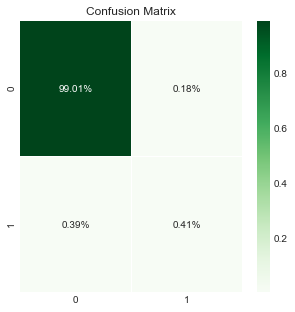

In [51]:
make_confusion_matrix(y_test,y_pred)

## Feature selection--Filter method

**1. Mutual Info between features and class label (drop date column for now)**

In [52]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [53]:
mi_reg = mutual_info_regression(X_filled, y_filled)
mi_cla = mutual_info_regression(X_filled, y_filled)

In [55]:
df_mi = pd.DataFrame(mi_reg, index=X_filled.columns, columns=['mutual_info_reg'])

In [56]:
def highlight_top6(s):
    """Highlight the maximum in a Series green."""
    is_large = s.nlargest(6).values
    return ['background-color: green' if v in is_large else '' for v in s ]

In [58]:
# top 6 are highlighted
df_mi.sort_values("mutual_info_reg", ascending=False).style.apply(highlight_top6)

,mutual_info_reg
test_indication_Contact with confirmed,0.012617
test_indication_Other,0.012534
fever,0.008028
head_ache,0.006923
cough,0.006077
sore_throat,0.003294
age_Missing,0.002600
age_No,0.002495
test_indication_Abroad,0.001526
age_Yes,0.001079


**Most features are nearly independent. No feature filtered out with this method**

In [59]:
# for scoring only, need to combine with other methods
from sklearn.feature_selection import f_regression, f_classif
f_reg = f_regression(X_filled, y_filled)
f_clasif = f_classif(X_filled, y_filled)

**2. Correlation matrix with heatmap for features in X_filled (missing values filled)**

In [60]:
# corr for mean
corr1 = X_filled.corr();
corr2 = X_dropped.corr();

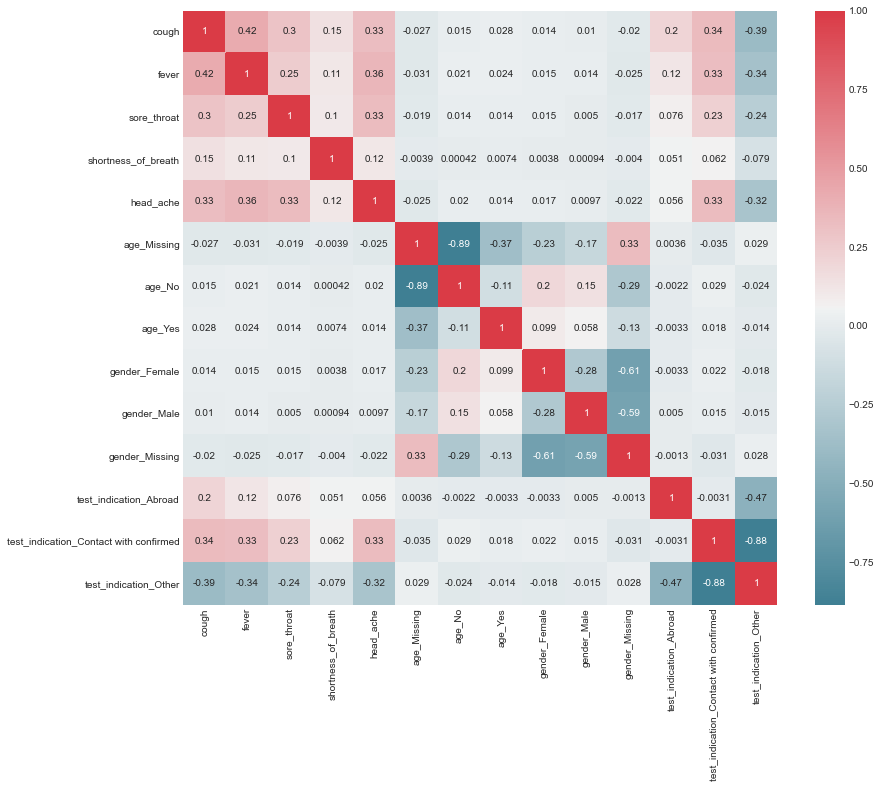

In [61]:
plt.rc("figure", figsize=(15, 15))
grid=sns.heatmap(corr1,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr1.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

**Findings: The correlations between any two features are low. No correlation is higher than 0.9. No feature filtered out with this method**

In [79]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [80]:
# # refresher
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)

In [81]:
# find best scored 5 features
selector = SelectKBest(chi2, k=5)
select_feature = selector.fit(x_train, y_train)
df_chi2 = pd.DataFrame(select_feature.scores_, index=x_train.columns, columns=['SelectKBest-chi2'])
df_chi2.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,SelectKBest-chi2
test_indication_Contact with confirmed,158010.337220
head_ache,89718.672696
fever,86302.881637
cough,80836.920359
sore_throat,49266.590647
shortness_of_breath,10495.983972
test_indication_Abroad,4337.282072
test_indication_Other,1095.707971
age_Yes,1004.287134
age_No,860.610150


In [82]:
# side-by-side comparison with mi
merged = df_chi2.join(df_mi)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,SelectKBest-chi2,mutual_info_reg
test_indication_Contact with confirmed,158010.337220,0.012617
head_ache,89718.672696,0.006923
fever,86302.881637,0.008028
cough,80836.920359,0.006077
sore_throat,49266.590647,0.003294
shortness_of_breath,10495.983972,0.000905
test_indication_Abroad,4337.282072,0.001526
test_indication_Other,1095.707971,0.012534
age_Yes,1004.287134,0.001079
age_No,860.610150,0.002495


In [83]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)

y_pred = make_y_pred(x_train_2, x_test_2, y_train)

In [84]:
results_select = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'SelectedKBest-chi2'])
results_select

,Method,SelectedKBest-chi2
0,Balanced Accuracy,0.802716
1,Sensitivity,0.993436
2,Specificity,0.611996
3,AUROC,0.802716
4,F1,0.597633
5,Geometric Mean,0.779730
6,Macro Average MAE,0.197284


In [101]:
results = results_1.set_index('Method').join(results_select.set_index('Method'))
results['%'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results

,Original,SelectedKBest-chi2,%
Method,,,
Balanced Accuracy,0.757924,0.802716,5.91%
Sensitivity,0.994292,0.993436,-0.09%
Specificity,0.521556,0.611996,17.34%
AUROC,0.757924,0.802716,5.91%
F1,0.592241,0.597633,0.91%
Geometric Mean,0.720124,0.779730,8.28%
Macro Average MAE,0.242076,0.197284,-18.5%


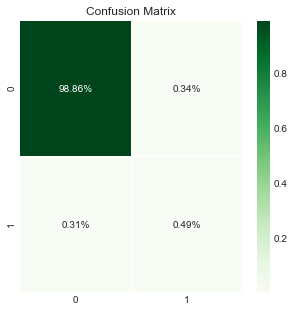

In [86]:
make_confusion_matrix(y_test,y_pred)

## Feature selection--Wrapper method

**Recursive feature elimination (RFE) with random forest**

In [282]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
# using the same classifer as original 
rfe = RFE(estimator=model_ori, n_features_to_select=6, step=1)
rfe = rfe.fit(x_train, y_train)

In [286]:
df_rfe = pd.DataFrame(rfe.support_, index=x_train.columns, columns=['RFE'])
df_rfe.sort_values('RFE', ascending=False).style.apply(highlight_top6)

,RFE
cough,True
fever,True
sore_throat,True
head_ache,True
test_indication_Contact with confirmed,True
test_indication_Other,True
shortness_of_breath,False
age_Missing,False
age_No,False
age_Yes,False


In [300]:
merged = df_mi.join(df_chi2.join(df_rfe))
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,mutual_info_reg,mutual_info_cla,SelectKBest-chi2,RFE
test_indication_Contact with confirmed,0.013334,0.012935,158010.337220,True
head_ache,0.006528,0.007470,89718.672696,True
fever,0.007590,0.007850,86302.881637,True
cough,0.007318,0.005212,80836.920359,True
sore_throat,0.003716,0.003370,49266.590647,True
shortness_of_breath,0.002267,0.002890,10495.983972,False
test_indication_Abroad,0.001621,0.002119,4337.282072,False
test_indication_Other,0.013476,0.014993,1095.707971,True
age_Yes,0.000000,0.000000,1004.287134,False
age_No,0.001154,0.000000,860.610150,False


**Findings: align mostly with SelectedKBest and the same as MI**

In [302]:
# TO DO:
# Why MI and RFE have test_indication_other

## <font color='red'> DO NOT RUN THE SECTION BELOW THROUGH THE RFECV TABLE, THIS WILL TAKE FOREVER</font> 



**Recursive feature elimination with cross validation and random forest classification**

In [324]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
# using the same classifer as original 
rfecv = RFECV(estimator=model_ori, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

In [305]:
df_RFECV = pd.DataFrame(rfecv.n_features_, index=x_train.columns, columns=['RFECV'])
df_RFECV.sort_values('RFECV', ascending=False).style.apply(highlight_top6)

,RFECV
cough,11
fever,11
sore_throat,11
shortness_of_breath,11
head_ache,11
age_Missing,11
age_No,11
age_Yes,11
gender_Female,11
gender_Male,11


grid_scores_ : array of shape [n_subsets_of_features]
The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.

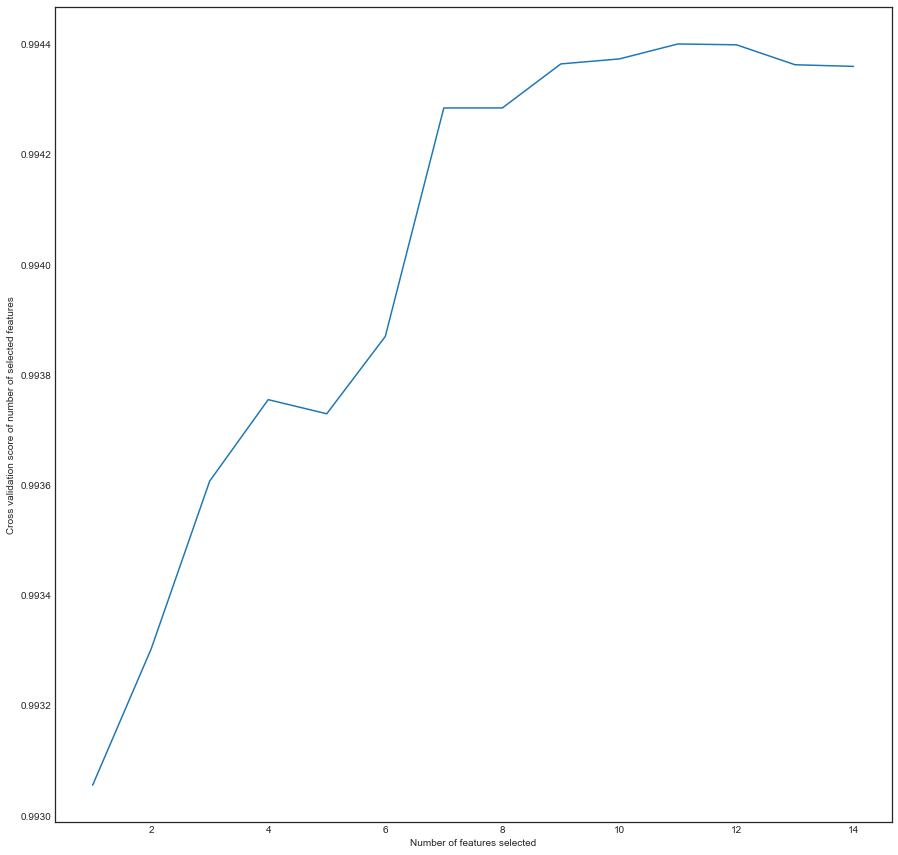

In [306]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**Findings: we can the validation score peaks at 8 features**

## Embedded Methods

**Random Forest Importance**

In [323]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [320]:
df_RF_importance = pd.DataFrame(clr_rf_5.feature_importances_, index=x_train.columns, columns=['RF_importance'])
df_RF_importance.sort_values('RF_importance', ascending=False).style.apply(highlight_top6)

,RF_importance
test_indication_Contact with confirmed,0.228877
test_indication_Other,0.210352
fever,0.143851
head_ache,0.128759
cough,0.109994
sore_throat,0.063201
age_Missing,0.026405
test_indication_Abroad,0.025798
shortness_of_breath,0.016707
gender_Missing,0.012650


In [321]:
merged = merged.join(df_RF_importance)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,mutual_info_reg,mutual_info_cla,SelectKBest-chi2,RFE,RFECV,RF_importance
test_indication_Contact with confirmed,0.013334,0.012935,158010.337220,True,0.229420,0.228877
head_ache,0.006528,0.007470,89718.672696,True,0.148273,0.128759
fever,0.007590,0.007850,86302.881637,True,0.147349,0.143851
cough,0.007318,0.005212,80836.920359,True,0.107414,0.109994
sore_throat,0.003716,0.003370,49266.590647,True,0.053000,0.063201
shortness_of_breath,0.002267,0.002890,10495.983972,False,0.016229,0.016707
test_indication_Abroad,0.001621,0.002119,4337.282072,False,0.025789,0.025798
test_indication_Other,0.013476,0.014993,1095.707971,True,0.201812,0.210352
age_Yes,0.000000,0.000000,1004.287134,False,0.012045,0.011820
age_No,0.001154,0.000000,860.610150,False,0.012359,0.011077


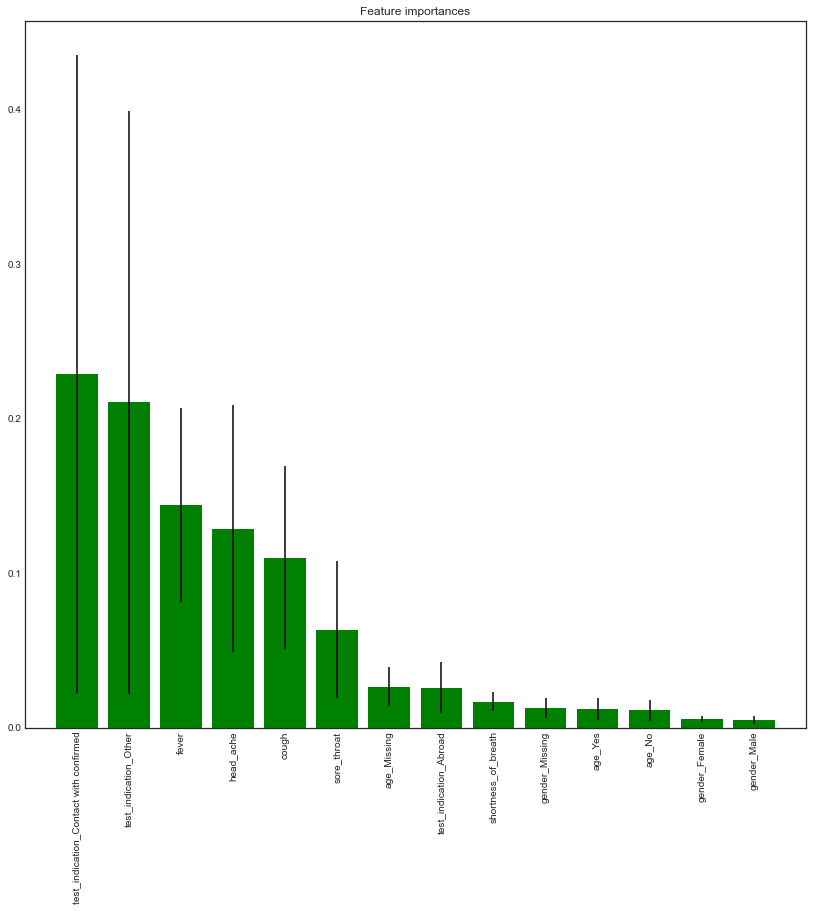

In [322]:
#  to determine how many should be selected

# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
     color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

**Feature Extraction with PCA**

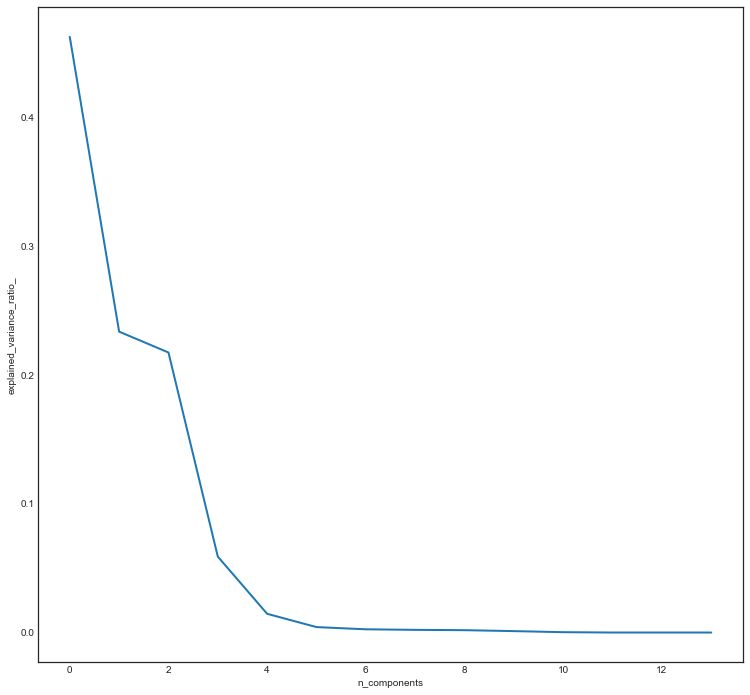

In [311]:
#  to determine how many should be selected
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_');

6 features are definitely enough

**Conclusion: We believe it's safe to select the top 6 features: 
'test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','shortness_of_breath'

**TO DO:
    validate if test_indication_Other should be dropped

In [95]:
#prepare the selected dataset with the 6th being test_indication_Other
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','test_indication_Other']
# X_selected = X_filled.drop("corona_result", axis = 1)
X_selected = X_filled[X_filled.columns[X_filled.columns.isin(selected_columns)]]

In [96]:
# update the train and test split
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_filled, test_size=0.2, random_state=0)

In [97]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [98]:
results_other = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=['Method', 'All other 5 methods'])
results_other

,Method,All other 5 methods
0,Balanced Accuracy,0.803585
1,Sensitivity,0.993677
2,Specificity,0.613493
3,AUROC,0.803585
4,F1,0.607196
5,Geometric Mean,0.780778
6,Macro Average MAE,0.196415


In [105]:
# results = results.set_index('Method').join(results_other.set_index('Method'))
results = results_1.set_index('Method').join(results_select.set_index('Method')).join(results_other.set_index('Method'))
results['original vs other 5 %'] = (((results['All other 5 methods'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results['original sel-chi2 %'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'

results

,Original,SelectedKBest-chi2,All other 5 methods,original vs other 5 %,original sel-chi2 %
Method,,,,,
Balanced Accuracy,0.757924,0.802716,0.803585,6.02%,5.91%
Sensitivity,0.994292,0.993436,0.993677,-0.06%,-0.09%
Specificity,0.521556,0.611996,0.613493,17.63%,17.34%
AUROC,0.757924,0.802716,0.803585,6.02%,5.91%
F1,0.592241,0.597633,0.607196,2.53%,0.91%
Geometric Mean,0.720124,0.779730,0.780778,8.42%,8.28%
Macro Average MAE,0.242076,0.197284,0.196415,-18.86%,-18.5%


**TO DO:
    selecting a subset from df.copy() may need to redo the normalization

In [332]:
#prepare the selected dataset with the 6th feature being shortness_of_breath
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','shortness_of_breath']
df_copy = df.copy()
X_selected = df.copy().drop("corona_result", axis = 1)
X_selected = X_selected[X_selected .columns[X_selected .columns.isin(selected_columns)]]

In [331]:
# update the train and test split
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_filled, test_size=0.2, random_state=0)

## Imbalanced sampling

https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling

pip install imbalanced-learn

In [54]:
# imbalance is just a tempt DF so I can test all the imbalance sampling methods

imbalance = df.copy()
imbalance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828717 entries, 0 to 852373
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   cough                828717 non-null  int64 
 1   fever                828717 non-null  int64 
 2   sore_throat          828717 non-null  int64 
 3   shortness_of_breath  828717 non-null  int64 
 4   head_ache            828717 non-null  int64 
 5   corona_result        828717 non-null  object
 6   age                  205769 non-null  object
 7   gender               365717 non-null  object
 8   test_indication      828717 non-null  object
dtypes: int64(5), object(4)
memory usage: 63.2+ MB


In [55]:
columns = imbalance.columns.tolist()
columns = [c for c in columns if c not in ["corona_result"]]
# Store the variable we are predicting 
target = "corona_result"

X = imbalance[columns]
Y = imbalance[target]

print(X.shape)
print(Y.shape)

(828717, 8)
(828717,)


In [56]:
Positive = df[df['corona_result']=='Positive']
Negative = df[df['corona_result']=='Negative']
print(Positive.shape,Negative.shape)

(6469, 9) (822248, 9)


**Oversampling: Naive random over-sampling to increase the sample size of under-represented data by replication**

In [57]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, Y)

print('Original {}'.format(Counter(Y)))
print('Resampled {}'.format(Counter(y_resampled)))

Original Counter({'Negative': 822248, 'Positive': 6469})
Resampled Counter({'Negative': 822248, 'Positive': 822248})


**Oversampling:SMOTE based on KNN and generating new samples**

** to be delete ** ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule

In [58]:
# not including ADASYN because it's takes forever to run

from imblearn.over_sampling import SMOTE

imbalance_smte = imbalance.copy()
imbalance_smte['corona_result'] = imbalance_smte['corona_result'].str.replace('Positive', '1')
imbalance_smte['corona_result'] = imbalance_smte['corona_result'].str.replace('Negative', '0')

# this is so that SMOTE can be use as it only accepts interge
imbalance_smte = imbalance_smte.drop(['age', 'gender', 'test_indication'], axis=1)

#imbalance_smt = imbalance_smt[:1000]

columns = imbalance_smte.columns.tolist()
columns = [c for c in columns if c not in ["corona_result"]]
# Store the variable we are predicting 
target = "corona_result"

Xsmte = imbalance_smte[columns]
Ysmte = imbalance_smte[target]

X_resampled, y_resampled = SMOTE().fit_resample(Xsmte, Ysmte)

#clf_smote = LinearSVC().fit(X_resampled, y_resampled)

print('Original {}'.format(Counter(Ysmte)))
print('Resampled {}'.format(Counter(y_resampled)))



Original Counter({'0': 822248, '1': 6469})
Resampled Counter({'0': 822248, '1': 822248})


**Under-sampling:RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes**

In [59]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, Y)


print('Original {}'.format(Counter(Y)))
print('Resampled {}'.format(Counter(y_resampled)))


Original Counter({'Negative': 822248, 'Positive': 6469})
Resampled Counter({'Negative': 6469, 'Positive': 6469})


(delete after review) **Mixture - SMOTETomek and SMOTEENN** Probably not going to be used as it takes too long to run on the entire dataset

SMOTETomek is somewhere upsampling and downsampling. SMOTETomek is a hybrid method which is a mixture of the above two methods, it uses an under-sampling method (Tomek) with an oversampling method (SMOTE). This is present within imblearn.combine module.

In [71]:
#https://analyticsindiamag.com/handling-imbalanced-datasets-a-guide-with-hands-on-implementation/
# this is for demo ONLY since it still running after 30min
# need to be deleted unless disagreed


from imblearn.combine import SMOTETomek 

imbalance_smt = imbalance.copy()


imbalance_smt['corona_result'] = imbalance_smt['corona_result'].str.replace('Positive', '1')
imbalance_smt['corona_result'] = imbalance_smt['corona_result'].str.replace('Negative', '0')

# this is so that SMOTETomek can be use as it only accepts int
imbalance_smt = imbalance_smt.drop(['age', 'gender', 'test_indication'], axis=1)

#limit to 1000 record to ensure the below is ran
imbalance_smt = imbalance_smt[:1000]

columns = imbalance_smt.columns.tolist()
columns = [c for c in columns if c not in ["corona_result"]]
# Store the variable we are predicting 
target = "corona_result"

Xsmt = imbalance_smt[columns]
Ysmt = imbalance_smt[target]

print(Xsmt.shape)
print(Ysmt.shape)

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(Xsmt, Ysmt)

print('Original {}'.format(Counter(Ysmt)))
print('Resampled {}'.format(Counter(y_resampled)))


smt = SMOTETomek()
X_resampled, y_resampled=smt.fit_resample(Xsmt,Ysmt)

print('Original {}'.format(Counter(Ysmt)))
print('Resampled {}'.format(Counter(y_resampled)))

(1000, 5)
(1000,)
Original Counter({'0': 985, '1': 15})
Resampled Counter({'0': 985, '1': 83})
Original Counter({'0': 985, '1': 15})
Resampled Counter({'0': 985, '1': 985})


**Stratified Kfold for imbalance data**

https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

Fix Cross-Validation for Imbalanced Classification
The solution is to not split the data randomly when using k-fold cross-validation or a train-test split.

Specifically, we can split a dataset randomly, although in such a way that maintains the same class distribution in each subset. This is called stratification or stratified sampling and the target variable (y), the class, is used to control the sampling process.

For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.


In [72]:
n_splits = 10
    
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for train_index, test_index in skf.split(X, Y):
    #need to replace below with model
    print("TRAIN:", train_index, "TEST:", test_index)


TRAIN: [     0      1      2 ... 828714 828715 828716] TEST: [     9     15     16 ... 828665 828668 828686]
TRAIN: [     0      1      2 ... 828712 828715 828716] TEST: [    40     51     56 ... 828710 828713 828714]
TRAIN: [     0      1      2 ... 828714 828715 828716] TEST: [     8     23     32 ... 828681 828687 828703]
TRAIN: [     0      2      3 ... 828713 828714 828715] TEST: [     1      4     10 ... 828704 828711 828716]
TRAIN: [     1      2      3 ... 828714 828715 828716] TEST: [     0     12     14 ... 828699 828707 828712]
TRAIN: [     0      1      2 ... 828713 828714 828716] TEST: [     3      5     20 ... 828694 828708 828715]
TRAIN: [     0      1      2 ... 828714 828715 828716] TEST: [     7     11     21 ... 828688 828693 828701]
TRAIN: [     0      1      2 ... 828714 828715 828716] TEST: [     6     17     19 ... 828696 828702 828709]
TRAIN: [     0      1      2 ... 828714 828715 828716] TEST: [    13     72    122 ... 828700 828705 828706]
TRAIN: [     0     

https://imbalanced-learn.org/stable/auto_examples/evaluation/plot_classification_report.html#sphx-glr-auto-examples-evaluation-plot-classification-report-py

In [1]:
# trying to compare
from imblearn.pipeline import make_pipeline as make_pipeline_imb

model = make_pipeline_imb(RandomOverSampler(random_state=0), 
                          RandomUnderSampler(random_state=0), 
                          RandomForestClassifier(random_state=0))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

NameError: name 'RandomOverSampler' is not defined

In [ ]:
pipeline = pl.make_pipeline(
    os.SMOTE(random_state=RANDOM_STATE), LinearSVC(random_state=RANDOM_STATE)
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

**Remaining work**
1. How to handle the imbalanced data (most of data is negative labeled)
2. Tuning the parameters of the classifiers
3. Feature selection(eg: Gender has the least mutual info with class value). If it is possible to improve performance  by removing these features
4. Sampling strategies (imbalanced sampling)
5. More data visualization
6. Try to classify with X_dropped (no missing value)
7. Try neurual network


8. can we track the improvement % for each sampling method, feature selection/deletion, models modification